# Labeling all data

In [1]:
import os
import json

%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

In [2]:
def preprocess(obj):
    obj["_id"] = obj["_id"]["$oid"]
    
    user = [
        "id",
        'screen_name',
        'statuses_count',
        "favourites_count",
        "followers_count",
        "friends_count"
    ]
    
    temp = {
        "id": obj["_id"],
        "text": obj["text"],
        "created_at": obj["created_at"]
    }
    
    for key in user:
        temp["user_"+key] = obj["user"][key]
    
    try:
        temp["geo"] = obj["geo"]
    except:
        temp["geo"] = None
        
    try:
        temp["place_country"] = obj["place"]["country"]
        temp["place_fullname"]= obj["place"]["full_name"]
    except:
        temp["place_country"] = None
        temp["place_fullname"]= None
        
    try:
        temp["source"] = obj["source"]
    except:
        pass
    return temp

def get_text(obj):
    return {
        "id": obj["_id"],
        "text": obj["text"]
    }

def iter_dir_contents(fpath, preprocess):
    for fn in os.listdir(fpath):
        fn = fpath + fn
        with open(fn, "r") as f:
            for line in f:
                yield preprocess(json.loads(line))
                
def data_control(preprocess):
    path = "/Users/JasonLiu/Downloads/research-data/drinking/split/"
    return iter_dir_contents(path, preprocess)

In [3]:
from itpy import Itpy

# Labeling and loading control data

### Loading data

In [48]:
%%time
df = pd.DataFrame.from_records(Itpy(data_control(preprocess))._)

CPU times: user 1min 9s, sys: 9.45 s, total: 1min 19s
Wall time: 1min 20s


In [ ]:
df = df.set_index("id").sort_index()

In [71]:
df[['created_at', 'geo', 'place_country', 'place_fullname', 'source',
       'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_id', 'user_screen_name',
       'user_statuses_count']].to_csv("bulk_control.csv")

### Loading and running all classifiers

In [50]:
from __private import fs

In [53]:
print(*fs.list(), sep="\n")

alcohol|accuracy:0.8143360752056404|f1:0.8192219679633866|type:LogisticRegression
alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC
alcohol|accuracy:0.8425381903642774|f1:0.8562231759656651|type:RandomForestClassifier
first_person_label|accuracy:0.5637860082304527|f1:0.5574430033343769|type:SVC
first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression
first_person|accuracy:0.6951871657754011|f1:0.8034482758620688|type:RandomForestClassifier
first_person|accuracy:0.7005347593582888|f1:0.7751004016064257|type:LogisticRegression
first_person|accuracy:0.7032085561497327|f1:0.8062827225130889|type:RandomForestClassifier
first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC


In [54]:
from classification import dao

In [73]:
%%time
alcohol_classifier = dao.ClassifierAccess.get_byfile(
    "alcohol|accuracy:0.8401880141010576|f1:0.8498896247240618|type:SVC"
)

CPU times: user 956 ms, sys: 694 ms, total: 1.65 s
Wall time: 24.8 s


In [75]:
%%time
alcohol_predictions = alcohol_classifier.predict_proba(df[["text"]])[:,1]
df["prediction_alcohol_svc"] = alcohol_predictions

CPU times: user 1h 34min 36s, sys: 2min 14s, total: 1h 36min 50s
Wall time: 1h 38min 51s


In [76]:
%%time
firstperson_classifier = dao.ClassifierAccess.get_byfile(
    "first_person|accuracy:0.7112299465240641|f1:0.8021978021978021|type:SVC"
)

CPU times: user 189 ms, sys: 209 ms, total: 398 ms
Wall time: 15.6 s


In [77]:
%%time
firstperson_predictions_svc = firstperson_classifier.predict_proba(df[["text"]])[:,1]
df["prediction_firstperson_svc"] = firstperson_predictions_svc

CPU times: user 39min 55s, sys: 1min 4s, total: 41min
Wall time: 41min 26s


In [78]:
%%time
firstpersonlevel_classifier = dao.ClassifierAccess.get_byfile(
    "first_person_label|accuracy:0.5637860082304527|f1:0.5643693591852614|type:LogisticRegression"
)

CPU times: user 125 ms, sys: 125 ms, total: 250 ms
Wall time: 6.93 s


In [81]:
%%time
firstpersonlevel_predictions = firstpersonlevel_classifier.predict_proba(df[["text"]])

CPU times: user 12min 51s, sys: 42.9 s, total: 13min 34s
Wall time: 13min 49s


In [88]:
df_firstpersonlevel_predictions = pd.DataFrame(
    firstpersonlevel_predictions, columns=[
        "prediction_firstperson_level_0", 
        "prediction_firstperson_level_2", 
        "prediction_firstperson_level_3"],
    index=df.index)

In [91]:
df = df.join(df_firstpersonlevel_predictions)

# Now we have all the labels...

1. write them
2. define breakpoints and plots

In [93]:
text = df[["text"]]

In [94]:
del df["text"]

In [96]:
df.to_csv("./labeled.control.dump.csv")

In [4]:
df = pd.DataFrame.from_csv("./labeled.control.dump.csv")

# Time Analysis

In [9]:
df["time"] = pd.to_datetime(df.created_at)
df = df.set_index("time")

In [10]:
dayofweek = (
    df.prediction_firstperson_svc.groupby(df.index.dayofweek).agg("mean") * 
    df.prediction_alcohol_svc.groupby(df.index.dayofweek).agg("mean")
)
dayofweek /= dayofweek.sum()

In [11]:
dayofweek = (
    df.prediction_firstperson_svc.groupby(df.index.dayofweek).agg("mean") * 
    df.prediction_alcohol_svc.groupby(df.index.dayofweek).agg("mean")
)
dayofweek /= dayofweek.sum()


freq = df.o.groupby(df.index.dayofweek).agg("sum") 
freq /= freq.sum()

dayofweek.index = ["M", "T", "W", "Th", "F", "S", "S"]
freq.index = ["M", "T", "W", "Th", "F", "S", "S"]

temp = pd.concat([freq, dayofweek], axis=1)
temp.columns = ["freq", "dayofweek"]
temp.plot(title="Day of week", figsize=(18, 6))

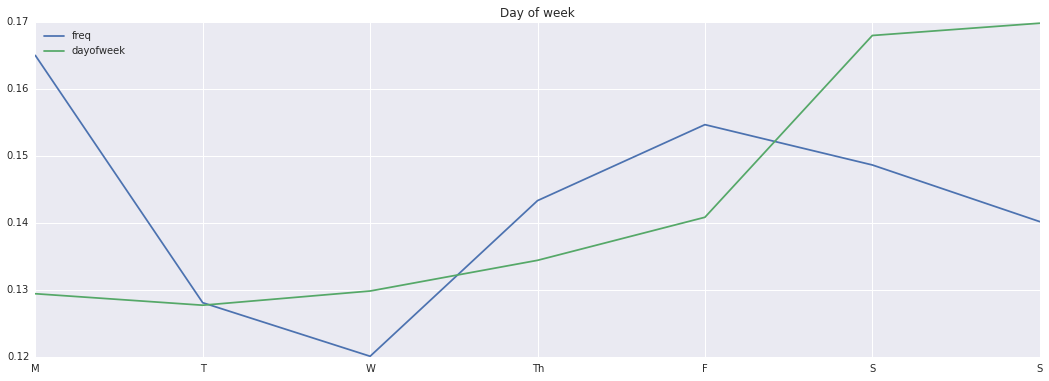

In [12]:
dayofweek.index = ["M", "T", "W", "Th", "F", "S", "S"]
freq.index = ["M", "T", "W", "Th", "F", "S", "S"]

temp = pd.concat([freq, dayofweek], axis=1)
temp.columns = ["freq", "dayofweek"]
temp.plot(title="Day of week", figsize=(18, 6))

In [13]:
hour = (
    df.prediction_firstperson_svc.groupby(df.index.hour).agg("mean") * 
    df.prediction_alcohol_svc.groupby(df.index.hour).agg("mean")
)
hour /= hour.sum()

freq = df.o.groupby(df.index.hour).agg("sum") 
freq /= freq.sum()

temp = pd.concat([freq, hour], axis=1)

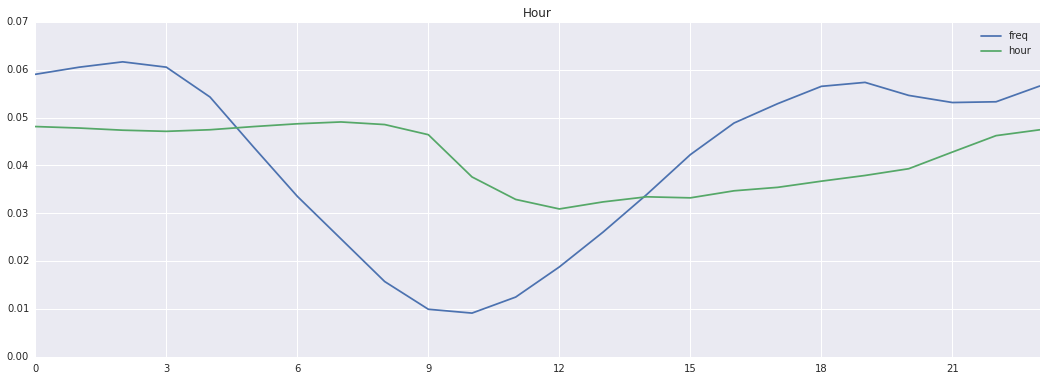

In [14]:
temp.columns = ["freq", "hour"]
temp.plot(title="Hour", xticks=[3*x for x in range(24//3)], figsize=(18, 6))

In [15]:
fp = pd.DataFrame([
 df.prediction_firstperson_level_0.groupby(df.index.hour).agg("mean"),
 df.prediction_firstperson_level_2.groupby(df.index.hour).agg("mean"),
 df.prediction_firstperson_level_3.groupby(df.index.hour).agg("mean")]).T
fp.columns = ["casual", "looking", "reflecting"]

for c in fp.columns: fp[c] = (fp[c] * hour) / (fp[c] * hour).sum()

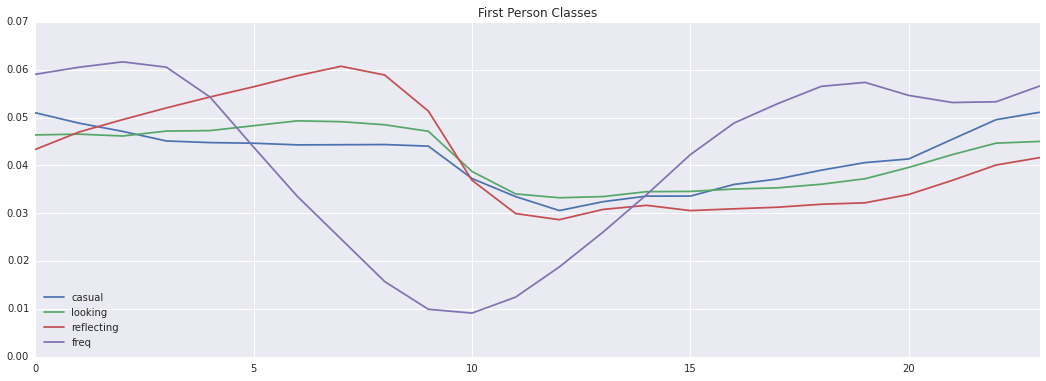

In [16]:
fp["freq"] = freq

fp.plot(title="First Person Classes", figsize=(18, 6))

In [17]:
dayhour = (
    df.prediction_firstperson_svc.groupby([df.index.dayofweek, df.index.hour]).agg("mean") * 
    df.prediction_alcohol_svc.groupby([df.index.dayofweek, df.index.hour]).agg("mean")
)
dayhour /= dayhour.sum()

freq = df.o.groupby([df.index.dayofweek, df.index.hour]).agg("sum")
freq /= freq.sum()

freq.index.levels = [["M", "T", "W", "Th", "F", "S", "S"], list(range(24))]
dayhour.index.levels = [["M", "T", "W", "Th", "F", "S", "S"], list(range(24))]

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/util/decorators.py:13: FutureWarning: setting `levels` directly is deprecated. Use set_levels instead
  FutureWarning)


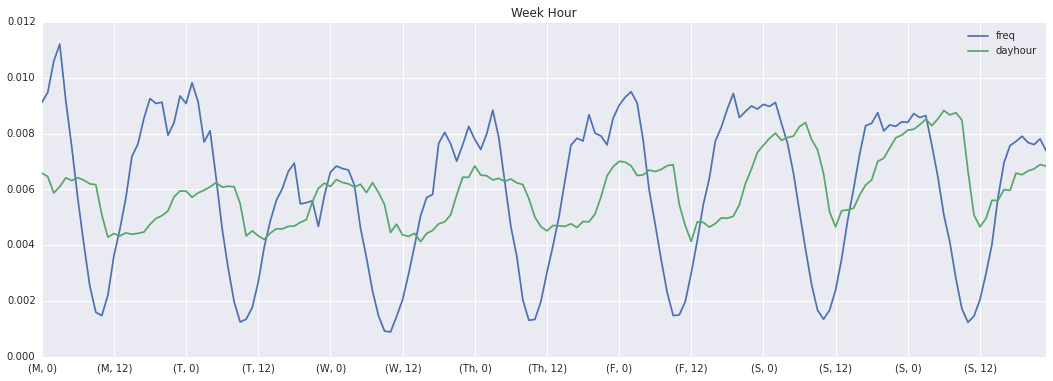

In [18]:
temp = pd.concat([freq, dayhour], axis=1)
temp.columns = ["freq", "dayhour"]

temp.plot(xticks=[_ for _ in range(24*7) if _%12==0], figsize=(18, 6), title="Week Hour")

In [19]:
fph = pd.DataFrame([
 df.prediction_firstperson_level_0.groupby([df.index.dayofweek, df.index.hour]).agg("mean"),
 df.prediction_firstperson_level_2.groupby([df.index.dayofweek, df.index.hour]).agg("mean"),
 df.prediction_firstperson_level_3.groupby([df.index.dayofweek, df.index.hour]).agg("mean")]).T

fph.columns = ["casual", "looking", "reflecting"]
fph.index.levels = [["M", "T", "W", "Th", "F", "S", "S"], list(range(24))]

for c in fph.columns: fph[c] = (fph[c] * dayhour) / (fph[c] * dayhour).sum()

In [20]:
bjjfph["freq"] = freq

fph.plot(xticks=[_ for _ in range(24*7) if _%12==0], figsize=(18, 6), title="Week Hour")

NameError: name 'bjjfph' is not defined

# 1. Take a look at how we can define point estimates for our time series.

# 2. sort users by frequency of alcohol related posts

# 3. State level

    1. maybe animate after normalizing timezones
    2. histogram
    3. cloropeth plots

In [ ]:
look at fp vs fp

In [ ]:
df["of_interest"] = of_interest

In [ ]:
gb_users = df.groupby("user_screen_name").agg(
    {
        "of_interest":"sum",
        "o":"sum"
    }
).sort("of_interest", ascending=0)

In [ ]:
gb_users[(gb_users.o > 10)].o.apply(pd.np.log).plot("hist")